# 导入python库并初始化overlay
本overlay可以实现PYNQ-Z2板载led,按键，拨码开关及hdmi的基本功能的调用,并在树莓派及Arduino的外设接口上实现了双摄像头视频的读取，及摇杆的基本控制

In [25]:
from pynq.overlay import Overlay
from pynq.lib.video import *
from pynq.lib.axigpio import *
import PIL.Image
from camera_init import *
from sccb import *
from joystick import *
import cv2
import asyncio
import numpy as np
import camera_configs
overlay = Overlay('Binocular_Vision.bit')

# 查看overlay属性
通过输入`overlay？`可以查看已加载的`overlay`的基本信息，如外部IP核(IP)，外部层次（Hierarchy），中断(Interupts)等

In [3]:
overlay?

# 初始化外部设备
本overlay包含下列外部设备

## (1) leds(AXIGPIO)
    
对应于板子上的LD0~LD3

## (2) switches(AXIGPIO)

对应于板子上的SW0~SW1,内有中断

## (3) buttons(AXIGPIO)

对应于板子上的BTN0~BTN3,内有中断

## (4) joystick(XADC_WIZARD/AXIGPIO)

overlay的外设，分为xy方向和z(内有中断)方向，下列是JOYSTICK模块和PYNQ-Z2的连接表


|  JOYSTICK  |    PYNQ-Z2   |
| ---------- |------------|
|    5V      |     3.3V     |
|    GND     |      GND     |
|    VRX     |      A0      |
|    VRY     |      A1      |
|    SW      |      A2      |

其中xy方向对应于为PL部分的XADC WIZARD
z方向对应于PL部分的AXIGPIO
## (5) vdmaL/vdmaR(VDMA Video Direct Memory Access)
        对应板子上的左摄像头和右摄像头的视频采集部分，摄像头采用OV7670模块
## (6) sccbL/sccbR(AXIIIC)
        对应板子上的左摄像头和右摄像头的寄存器控制总线 SCCB(Serial Camera Controll Bus),加载了SCCB类以配置寄存器
## (7) hdmi
        提供hdmi输入和输出

In [2]:
#leds
leds = overlay.LEDS
leds.setdirection(AxiGPIO.Output)
leds.setlength(4)

#switches
switches = overlay.SWITCHES
switches.setlength(2)
switches.setdirection(AxiGPIO.Input)

#buttons
buttons = overlay.BUTTONS
buttons.setlength(4)
buttons.setdirection(AxiGPIO.Input)

#joystick
joystick = Joystick(overlay.JOYSTICK_XY,overlay.JOYSTICK_Z)

#vdma
vdmaR = overlay.CAM_R_VDMA
vdmaL = overlay.CAM_L_VDMA
vdma_remap = overlay.REMAP
vdma_stereoBM = overlay.DISPARITY
vdma_pseudo = overlay.PSEUDO

#sccb
sccbR = SCCB(overlay.CAM_R_SCCB,0x42)
sccbL = SCCB(overlay.CAM_L_SCCB,0x42)

#hdmi
hdmi_in = overlay.video.hdmi_in
hdmi_out = overlay.video.hdmi_out

#hardware acceleration
remap_hls = overlay.remap_hls_v4
stereoBM_hls = overlay.stereoBM_hls
pseudo_hls = overlay.gray2pseudocolor

# 基本IO的使用
    PYNQ-Z2板上的基本IO有led,按键，拨码开关等

## LED的使用
对于led[0]~led[3]，可以使用

`leds[i].on()`和`leds[i].off()`控制 

也可使用`leds[i].write(bool)`  --`bool`为写入的开关量

或者`leds.write(0x0,num)`    --`num`为写入的4位二进制数

In [3]:
leds[0].on()

In [4]:
leds[0].off()

In [5]:
leds.write(0x0,0xa)

# 按键开关,拨码开关的使用
对于button[0]~button[3]，switch[0]~switch[1],可使用`device[i].read()`读取按键的值,也可使`device.read(0x0)`读取对应的器件的所有输出

In [36]:
buttons[0].read()

0

In [37]:
switches.read(0x0)

0

In [38]:
buttons[0].wait_for_value(1)

In [39]:
switches[0].wait_for_value(1)

# Joystick的使用

使用`joystick.read_z()`获取Joystick按键的状态(注意，joystick_z为常闭开关)

使用`joystick.read_xy()`获取Joystick坐标轴的状态
预定义了DIRECTION_VALUE_MAP键值表，获得对应的状态

In [43]:
joystick = Joystick(overlay.JOYSTICK_XY,overlay.JOYSTICK_Z)

In [49]:
DIRECTION_VALUE_MAP[joystick.read_xy()]

'up_left'

# 初始化摄像头的寄存器

In [3]:
InitCamera_VGA(sccbR)
InitCamera_VGA(sccbL)

# 配置VDMA

In [4]:
framemode = VideoMode(640,480, 24)

vdmaL.readchannel.mode = framemode
vdmaL.readchannel.start()

vdmaR.readchannel.mode = framemode
vdmaR.readchannel.start()

framemode = VideoMode(640,480, 24)

vdma_remap.writechannel.mode = framemode
vdma_remap.writechannel.start()

framemode = VideoMode(640,480, 8)
vdma_remap.readchannel.mode = framemode
vdma_remap.readchannel.start()

framemode = VideoMode(640,480, 16)

vdma_stereoBM.writechannel.mode = framemode
vdma_stereoBM.writechannel.start()

vdma_stereoBM.readchannel.mode = framemode
vdma_stereoBM.readchannel.start()

framemode = VideoMode(640,480, 8)

vdma_pseudo.writechannel.mode = framemode
vdma_pseudo.writechannel.start()

framemode = VideoMode(640,480, 24)

vdma_pseudo.readchannel.mode = framemode
vdma_pseudo.readchannel.start()

## 读取左通道和右通道的图像

In [5]:
frameL = vdmaL.readchannel.readframe()
frameR = vdmaR.readchannel.readframe()

# remap硬件加速
------------------------Address Info-------------------

0x00 : Control signals

    bit 0  - ap_start (Read/Write/COH)

    bit 1  - ap_done (Read/COR)
    
    bit 2  - ap_idle (Read)

    bit 3  - ap_ready (Read)
    
    bit 7  - auto_restart (Read/Write)
    
    others - reserved

0x04 : Global Interrupt Enable Register

    bit 0  - Global Interrupt Enable (Read/Write)
    
    others - reserved

0x08 : IP Interrupt Enable Register (Read/Write)
    
    bit 0  - Channel 0 (ap_done)

    bit 1  - Channel 1 (ap_ready)
    
    others - reserved

0x0c : IP Interrupt Status Register (Read/TOW)
    
    bit 0  - Channel 0 (ap_done)
    
    bit 1  - Channel 1 (ap_ready)
    
    others - reserved

0x14 : Data signal of rows
    
    bit 31~0 - rows[31:0] (Read/Write)

0x18 : reserved

0x1c : Data signal of cols

    bit 31~0 - cols[31:0] (Read/Write)

0x20 : reserved

0x40 ~

0x7f : Memory 'cameraMA_V' (9 * 32b)

    Word n : bit [31:0] - cameraMA_V[n]

0x80 ~
   
0x9f : Memory 'distC2_V' (5 * 32b)
    
    Word n : bit [31:0] - distC2_V[n]
        
0xc0 ~

0xff : Memory 'RMA_V' (9 * 32b)
        Word n : bit [31:0] - RMA_V[n]
(SC = Self Clear, COR = Clear on Read, TOW = Toggle on Write, COH = Clear on Handshake)

## camera,R,distort 为32位定点数矩阵，其整数部分位宽分别为14，4，4

0.019385099411010742


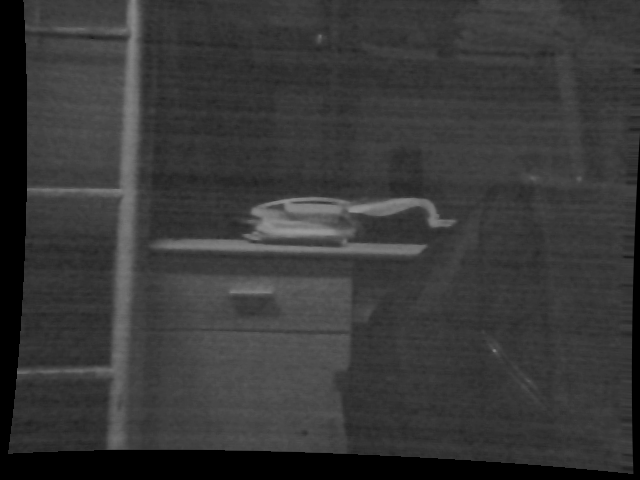

In [17]:
import time

start = time.time()

#初始化图像行列信息

remap_hls.write(0x014,480)
remap_hls.write(0x01c,640)

#初始化 内参，外参，畸变矩阵

#camera
remap_hls.write(0x040,0x4b2f775)
remap_hls.write(0x044,0x0000000)
remap_hls.write(0x048,0x16e249f)
remap_hls.write(0x04c,0x0000000)
remap_hls.write(0x050,0x48fb95d)
remap_hls.write(0x054,0x0dca221)
remap_hls.write(0x058,0x0000000)
remap_hls.write(0x05c,0x0000000)
remap_hls.write(0x060,0x0010000)

#R
remap_hls.write(0x0c0,0x0003b30f)
remap_hls.write(0x0c4,0x00002020)
remap_hls.write(0x0c8,0xfa7f2234)
remap_hls.write(0x0cc,0xffffe016)
remap_hls.write(0x0d0,0x0003b363)
remap_hls.write(0x0d4,0xfd34944e)
remap_hls.write(0x0d8,0x00001a41)
remap_hls.write(0x0dc,0xfffff88a)
remap_hls.write(0x0e0,0x0fe15bda)

#Distort
remap_hls.write(0x080,0xf96809d4)
remap_hls.write(0x084,0xf4d53cdd)
remap_hls.write(0x088,0x003a7daa)
remap_hls.write(0x08C,0xffdb0dd8)
remap_hls.write(0x090,0x00000000)

#设置控制寄存器为重复开始
remap_hls.write(0x000,0x81)
vdma_remap.writechannel.writeframe(frameL)
remap1 = vdma_remap.readchannel.readframe()
print(time.time()-start)
img = PIL.Image.fromarray(remap1)
img

0.018208742141723633


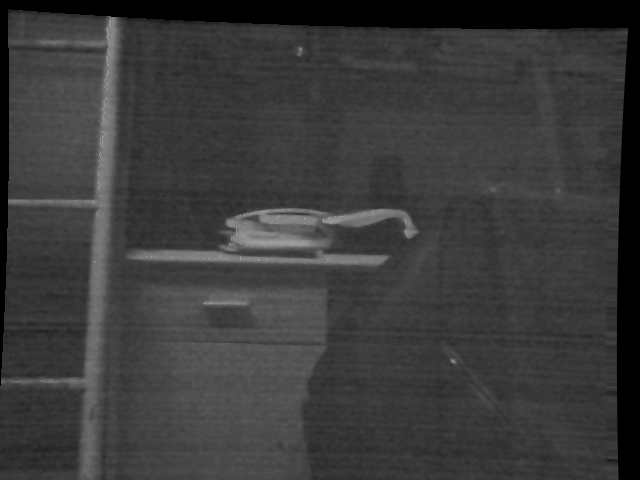

In [23]:
import time
start = time.time()

#初始化 内参，外参，畸变矩阵

#camera
remap_hls.write(0x040,0x4aa2f4f)
remap_hls.write(0x044,0x00000)
remap_hls.write(0x048,0x14aab17)
remap_hls.write(0x04c,0x00000)
remap_hls.write(0x050,0x4869c78)
remap_hls.write(0x054,0xcc8445)
remap_hls.write(0x058,0x00000)
remap_hls.write(0x05c,0x00000)
remap_hls.write(0x060,0x10000)

#R
remap_hls.write(0x0c0,0x3b38a)
remap_hls.write(0x0c4,0x17b3)
remap_hls.write(0x0c8,0xfb37feb9)
remap_hls.write(0x0cc,0xffffe86d)
remap_hls.write(0x0d0,0x3b3a2)
remap_hls.write(0x0d4,0xfce22cae)
remap_hls.write(0x0d8,0xfffff07e)
remap_hls.write(0x0dc,0x7b5)
remap_hls.write(0x0e0,0x100da46d)

#Distort
remap_hls.write(0x080,0xf9eb9a17)
remap_hls.write(0x084,0xfe4169c2)
remap_hls.write(0x088,0x18f1d3)
remap_hls.write(0x08C,0xffffd60e)
remap_hls.write(0x090,0x00000000)

vdma_remap.writechannel.writeframe(frameR)
remap2 = vdma_remap.readchannel.readframe()
print(time.time()-start)
img = PIL.Image.fromarray(remap2)
img

# 与cv2库做对比

0.10811758041381836


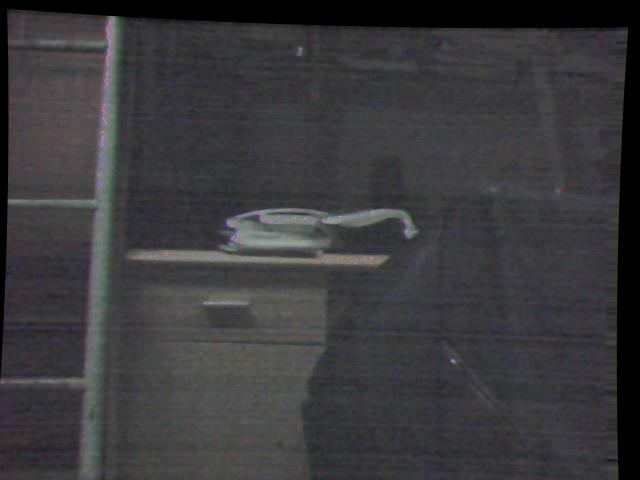

In [24]:
import time
start = time.time()
img1_rectified = cv2.remap(frameL, camera_configs.left_map1, camera_configs.left_map2, cv2.INTER_LINEAR)
img2_rectified = cv2.remap(frameR, camera_configs.right_map1, camera_configs.right_map2, cv2.INTER_LINEAR)
imgL = cv2.cvtColor(img1_rectified, cv2.COLOR_BGR2GRAY)
imgR = cv2.cvtColor(img2_rectified, cv2.COLOR_BGR2GRAY)
print(time.time()-start)

img = PIL.Image.fromarray(img2_rectified)
img

# 初始化 stereoBM

------------------------Address Info-------------------

0x00 : Control signals

    bit 0  - ap_start (Read/Write/COH)

    bit 1  - ap_done (Read/COR)
    
    bit 2  - ap_idle (Read)

    bit 3  - ap_ready (Read)
    
    bit 7  - auto_restart (Read/Write)
    
    others - reserved

0x04 : Global Interrupt Enable Register

    bit 0  - Global Interrupt Enable (Read/Write)
    
    others - reserved

0x08 : IP Interrupt Enable Register (Read/Write)
    
    bit 0  - Channel 0 (ap_done)

    bit 1  - Channel 1 (ap_ready)
    
    others - reserved

0x0c : IP Interrupt Status Register (Read/TOW)
    
    bit 0  - Channel 0 (ap_done)
    
    bit 1  - Channel 1 (ap_ready)
    
    others - reserved

0x14 : Data signal of rows
    
    bit 31~0 - rows[31:0] (Read/Write)

0x18 : reserved

0x1c : Data signal of cols

    bit 31~0 - cols[31:0] (Read/Write)

0x20 : reserved

(SC = Self Clear, COR = Clear on Read, TOW = Toggle on Write, COH = Clear on Handshake)

In [21]:
#初始化图像行列信息

stereoBM_hls.write(0x014,480)
stereoBM_hls.write(0x01c,640)
stereoBM_hls.write(0x000,0x81)

# 调用stereoBM硬件库

0.023324012756347656


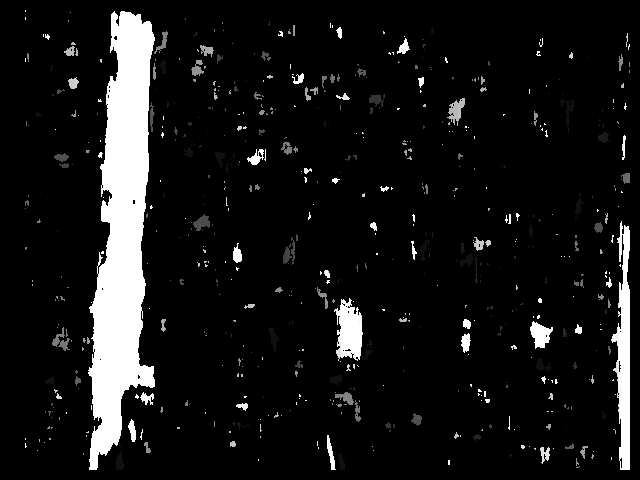

In [22]:
import time
start = time.time()
frame = vdma_stereoBM.writechannel.newframe()
frame[:,:,0] = remap1
frame[:,:,1] = remap2
vdma_stereoBM.writechannel.writeframe(frame)

rem11 = vdma_stereoBM.readchannel.readframe()
print(time.time()-start)
rem11.dtype = 'int16'
disp = cv2.normalize(rem11, rem11, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)  

img = PIL.Image.fromarray(disp)
img

# 与cv2库函数对比

0.30613112449645996


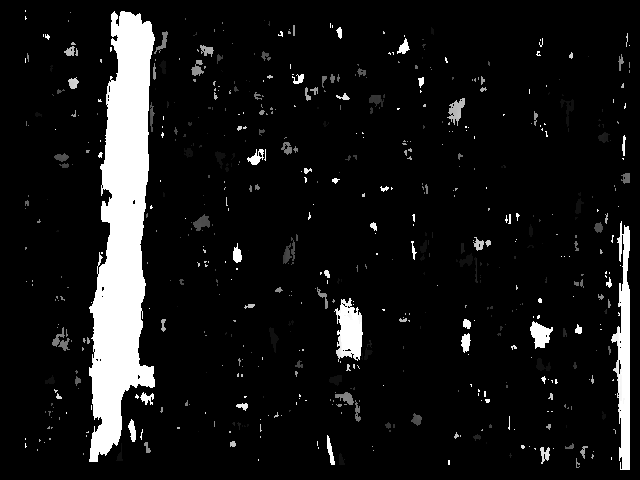

In [13]:
start = time.time()
stereo = cv2.StereoBM_create(numDisparities = 16, blockSize=21)
disparity = stereo.compute(remap1,remap2)
print(time.time()-start)
disp = cv2.normalize(disparity, disparity, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)  
img = PIL.Image.fromarray(disp)
img

# 初始化 伪色彩图


0x00 : Control signals

    bit 0  - ap_start (Read/Write/COH)

    bit 1  - ap_done (Read/COR)
    
    bit 2  - ap_idle (Read)

    bit 3  - ap_ready (Read)
    
    bit 7  - auto_restart (Read/Write)
    
    others - reserved

0x04 : Global Interrupt Enable Register

    bit 0  - Global Interrupt Enable (Read/Write)
    
    others - reserved

0x08 : IP Interrupt Enable Register (Read/Write)
    
    bit 0  - Channel 0 (ap_done)

    bit 1  - Channel 1 (ap_ready)
    
    others - reserved

0x0c : IP Interrupt Status Register (Read/TOW)
    
    bit 0  - Channel 0 (ap_done)
    
    bit 1  - Channel 1 (ap_ready)
    
    others - reserved

0x14 : Data signal of rows
    
    bit 31~0 - rows[31:0] (Read/Write)

0x18 : reserved

0x1c : Data signal of cols

    bit 31~0 - cols[31:0] (Read/Write)

0x20 : reserved

(SC = Self Clear, COR = Clear on Read, TOW = Toggle on Write, COH = Clear on Handshake)

In [14]:
pseudo_hls.write(0x014,480)
pseudo_hls.write(0x01c,640)
pseudo_hls.write(0x000,0x81)

0.0312952995300293


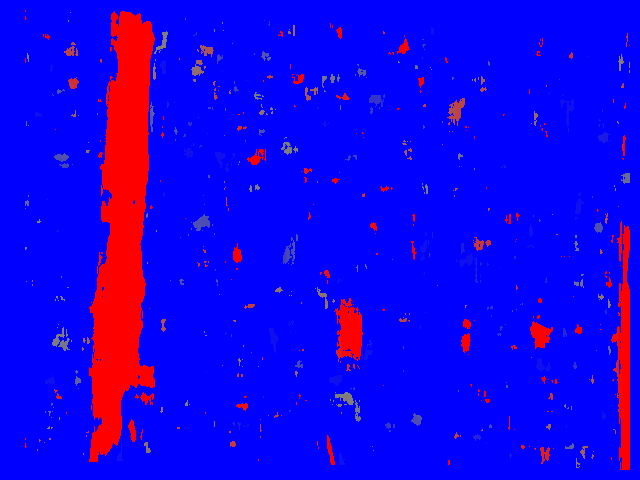

In [15]:
import time
start = time.time()
frame = vdma_pseudo.writechannel.newframe()
frame[:,:] =disp
vdma_pseudo.writechannel.writeframe(frame)

pseudo_img = vdma_pseudo.readchannel.readframe()
print(time.time()-start)

img = PIL.Image.fromarray(pseudo_img)
img

# HDMI_out的使用

## 初始化HDMI_out

In [ ]:
framemode = VideoMode(1920,1080, 24,60)
hdmi_out.configure(framemode, PIXEL_RGB)
hdmi_out.start()

## 通过VDMA输出HDMI视频信号

## 结束HDMI_out

In [ ]:
import time
numframes = 6000
start = time.time()
for _ in range(numframes):
    outframe = hdmi_out.newframe()
    hdmi_out.writeframe(outframe)
end = time.time()
print("Frames per second:  " + str(numframes / (end - start)))

In [9]:
hdmi_out.stop()
del hdmi_out